In [1]:
import os, sys
import numpy as np
import tensorflow as tf
import tensorflow.compat.v1 as tf 
tf.disable_v2_behavior()

# 일관된 출력을 위해 유사난수 초기화
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
# matplotlib.rc('font', family='AppleGothic')  # MacOS
# matplotlib.rc('font', family='Malgun Gothic')  # Windows
matplotlib.rc('font', family='NanumBarunGothic') # Linux
plt.rcParams['axes.unicode_minus'] = False

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")
    
def plot_multiple_images(images, n_rows, n_cols, pad=2):
    images = images - images.min()  # 최소값을 0으로 만들어 패딩이 하얗게 보이도록 합니다.
    w,h = images.shape[1:]
    image = np.zeros(((w+pad)*n_rows+pad, (h+pad)*n_cols+pad))
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y*(h+pad)+pad):(y*(h+pad)+pad+h),(x*(w+pad)+pad):(x*(w+pad)+pad+w)] = images[y*n_cols+x]
    plt.imshow(image, cmap="Greys", interpolation="nearest")
    plt.axis("off")

In [2]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()
train_x = train_x.astype(np.float32).reshape(-1, 28*28) / 255.0
test_x = test_x.astype(np.float32).reshape(-1, 28*28) / 255.0
train_y = train_y.astype(np.int32)
test_y = test_y.astype(np.int32)
valid_x, train_x = train_x[:5000], train_x[5000:]
valid_y, train_y = train_y[:5000], train_y[5000:]

# Mini-batch
def shuffle_batch(features, labels, batch_size):
    rnd_idx = np.random.permutation(len(features))
    n_batches = len(features) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        batch_x, batch_y = features[batch_idx], labels[batch_idx]
        yield batch_x, batch_y

In [21]:
reset_graph()

from functools import partial

################
# layer params #
################
n_inputs = 28 * 28
n_hidden1 = 300  # encoder
n_hidden2 = 150  # coding units
n_hidden3 = n_hidden1  # decoder
n_outputs = n_inputs  # reconstruction

################
# train params #
################
learning_rate = 0.01
l2_reg = 0.0001
n_epochs = 5
batch_size = 150
n_batches = len(train_x) // batch_size

# set the layers using partial
he_init = tf.keras.initializers.he_normal()  # He 초기화
l2_regularizer = tf.keras.regularizers.l2(l2_reg)
dense_layer = partial(tf.layers.dense,
                      activation=tf.nn.elu,
                      kernel_initializer=he_init,
                      kernel_regularizer=l2_regularizer)

# stacked autoencoder
inputs = tf.placeholder(tf.float32, shape=[None, n_inputs])

hidden1 = dense_layer(inputs, n_hidden1)
hidden2 = dense_layer(hidden1, n_hidden2)
hidden3 = dense_layer(hidden2, n_hidden3)
outputs = dense_layer(hidden3, n_outputs, activation=None)

# loss
reconstruction_loss = tf.reduce_mean(tf.square(outputs - inputs))
reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([reconstruction_loss] + reg_losses)

# optimizer
train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)

# Saver
saver = tf.train.Saver(max_to_keep=1)

In [22]:
%%time
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for epoch in range(n_epochs):
        for iteration in range(n_batches):
            batch_x, batch_y = next(shuffle_batch(train_x, train_y, batch_size))
            sess.run(train_op, feed_dict={inputs: batch_x})
        loss_train = reconstruction_loss.eval(feed_dict={inputs: batch_x})
        print('epoch : {}, Train MSE : {:.5f}'.format(epoch, loss_train))
    saver.save(sess, './model/stacked_ae.ckpt')

epoch : 0, Train MSE : 0.01934
epoch : 1, Train MSE : 0.01342
epoch : 2, Train MSE : 0.01485
epoch : 3, Train MSE : 0.01505
epoch : 4, Train MSE : 0.01502
CPU times: user 33.5 s, sys: 21.2 s, total: 54.7 s
Wall time: 24.7 s


INFO:tensorflow:Restoring parameters from ./model/stacked_ae.ckpt


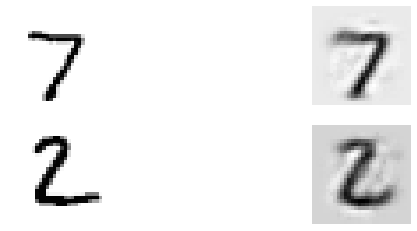

In [23]:
def show_reconstructed_digits(X, outputs, model_path=None, n_test_digits=2):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        outputs_val = outputs.eval(feed_dict={inputs: test_x[:n_test_digits]})

    fig = plt.figure(figsize=(10, 4))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(test_x[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])
        
show_reconstructed_digits(inputs, outputs, './model/stacked_ae.ckpt')

epoch : 0, Train MSE : 0.02303
epoch : 1, Train MSE : 0.02314
epoch : 2, Train MSE : 0.02582
epoch : 3, Train MSE : 0.02596
epoch : 4, Train MSE : 0.02501
INFO:tensorflow:Restoring parameters from ./model/stacked_ae_tying.ckpt


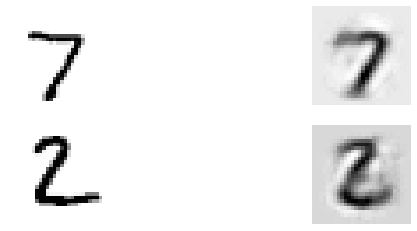

In [27]:
reset_graph()

################
# layer params #
################
n_inputs = 28 * 28
n_hidden1 = 300  # encoder
n_hidden2 = 150  # coding units
n_hidden3 = n_hidden1  # decoder
n_outputs = n_inputs  # reconstruction

################
# train params #
################
learning_rate = 0.01
l2_reg = 0.0005
n_epochs = 5
batch_size = 150
n_batches = len(train_x) // batch_size

# set the layers using partial
activation = tf.nn.elu
weight_initializer = tf.keras.initializers.he_normal()  # He 초기화
l2_regularizer = tf.keras.regularizers.l2(l2_reg)  # L2 규제

inputs = tf.placeholder(tf.float32, shape=[None, n_inputs])

W1_init = weight_initializer([n_inputs, n_hidden1])
W2_init = weight_initializer([n_hidden1, n_hidden2])

# Encoder weights
W1 = tf.Variable(W1_init, dtype=tf.float32, name='W1')
W2 = tf.Variable(W2_init, dtype=tf.float32, name='W2')
# Decoder weights
W3 = tf.transpose(W2, name='W3')  # 가중치 묶기
W4 = tf.transpose(W1, name='W4')  # 가중치 묶기

# bias
b1 = tf.Variable(tf.zeros(n_hidden1), name='b1')
b2 = tf.Variable(tf.zeros(n_hidden2), name='b2')
b3 = tf.Variable(tf.zeros(n_hidden3), name='b3')
b4 = tf.Variable(tf.zeros(n_outputs), name='b4')

hidden1 = activation(tf.matmul(inputs, W1) + b1)
hidden2 = activation(tf.matmul(hidden1, W2) + b2)
hidden3 = activation(tf.matmul(hidden2, W3) + b3)
outputs = tf.matmul(hidden3, W4) + b4

# loss
reconstruction_loss = tf.reduce_mean(tf.square(outputs - inputs))
reg_loss = l2_regularizer(W1) + l2_regularizer(W2)
loss = reconstruction_loss + reg_loss

# optimizer
train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)

# saver
saver = tf.train.Saver()

# Train
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for epoch in range(n_epochs):
        for iteration in range(n_batches):
            batch_x, batch_y = next(shuffle_batch(train_x, train_y, batch_size))
            sess.run(train_op, feed_dict={inputs: batch_x})
        loss_train = reconstruction_loss.eval(feed_dict={inputs: batch_x})
        print('epoch : {}, Train MSE : {:.5f}'.format(epoch, loss_train))
    saver.save(sess, './model/stacked_ae_tying.ckpt')
    
show_reconstructed_digits(inputs, outputs, './model/stacked_ae_tying.ckpt')

In [30]:
from functools import partial

reset_graph()

# Mini-batch
def shuffle_batch(features, labels, batch_size):
    rnd_idx = np.random.permutation(len(features))
    n_batches = len(features) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        batch_x, batch_y = features[batch_idx], labels[batch_idx]
        yield batch_x, batch_y

def train_autoencoder(train_x, n_neurons, n_epochs, batch_size, 
                      learning_rate=0.01, l2_reg=0.0005, seed=42,
                      hidden_activation=tf.nn.elu, 
                      output_activation=tf.nn.elu):

    graph = tf.Graph()
    with graph.as_default():
        tf.set_random_seed(seed)
        
        n_inputs = train_x.shape[1]
        
        inputs = tf.placeholder(tf.float32, shape=[None, n_inputs])
        
        dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=tf.keras.initializers.he_normal(), 
            kernel_regularizer=tf.keras.regularizers.l2(l2_reg))
        
        hidden = dense_layer(inputs, n_neurons, activation=hidden_activation, name='hidden')
        outputs = dense_layer(hidden, n_inputs, activation=output_activation, name='outputs')
        
        reconstruction_loss = tf.losses.mean_squared_error(labels=inputs, predictions=outputs)
        
        reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        loss = tf.add_n([reconstruction_loss] + reg_losses)

        optimizer = tf.train.AdamOptimizer(learning_rate)
        train_op = optimizer.minimize(loss)
        
    with tf.Session(graph=graph) as sess:
        tf.global_variables_initializer().run()
        n_batches = len(train_x) // batch_size
        for epoch in range(n_epochs):
            batch_x = None
            for iteration in range(n_batches):
                batch_x, batch_y = next(shuffle_batch(train_x, train_y, batch_size))
                sess.run(train_op, feed_dict={inputs: batch_x})
            loss_train = reconstruction_loss.eval(feed_dict={inputs: batch_x})
            print('epoch : {}, Train MSE : {:.5f}'.format(epoch, loss_train))
            
        params = dict([(var.name, var.eval()) for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)])
        hidden_val = hidden.eval(feed_dict={inputs: train_x})
        
    return hidden_val, params["hidden/kernel:0"], params["hidden/bias:0"], params["outputs/kernel:0"], params["outputs/bias:0"]

In [31]:
hidden_output, W1, b1, W4, b4 = train_autoencoder(train_x, n_neurons=300, n_epochs=4, batch_size=150,
                                                  output_activation=None)

epoch : 0, Train MSE : 0.02651
epoch : 1, Train MSE : 0.02546
epoch : 2, Train MSE : 0.02801
epoch : 3, Train MSE : 0.02761


In [32]:
_, W2, b2, W3, b3 = train_autoencoder(hidden_output, n_neurons=150, n_epochs=4, batch_size=150)

epoch : 0, Train MSE : 0.00532
epoch : 1, Train MSE : 0.00540
epoch : 2, Train MSE : 0.00559
epoch : 3, Train MSE : 0.00548


In [33]:
reset_graph()

n_inputs = 28*28

inputs = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden1 = tf.nn.elu(tf.matmul(inputs, W1) + b1)
hidden2 = tf.nn.elu(tf.matmul(hidden1, W2) + b2)
hidden3 = tf.nn.elu(tf.matmul(hidden2, W3) + b3)
outputs = tf.matmul(hidden3, W4) + b4

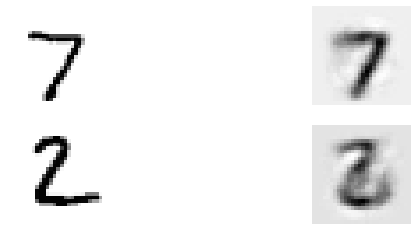

In [34]:
show_reconstructed_digits(inputs, outputs)

In [39]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # 코딩 유닛
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

activation = tf.nn.elu
regularizer = tf.keras.regularizers.l2(l2_reg)
initializer = tf.variance_scaling_initializer()

W1_init = initializer([n_inputs, n_hidden1])
W2_init = initializer([n_hidden1, n_hidden2])
W3_init = initializer([n_hidden2, n_hidden3])
W4_init = initializer([n_hidden3, n_outputs])

W1 = tf.Variable(W1_init, dtype=tf.float32, name="weights1")
W2 = tf.Variable(W2_init, dtype=tf.float32, name="weights2")
W3 = tf.Variable(W3_init, dtype=tf.float32, name="weights3")
W4 = tf.Variable(W4_init, dtype=tf.float32, name="weights4")

b1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
b2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
b3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
b4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

inputs = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden1 = activation(tf.matmul(inputs, W1) + b1)
hidden2 = activation(tf.matmul(hidden1, W2) + b2)
hidden3 = activation(tf.matmul(hidden2, W3) + b3)
outputs = tf.matmul(hidden3, W4) + b4

reconstruction_loss = tf.losses.mean_squared_error(labels=inputs, predictions=outputs)

In [40]:
optimizer = tf.train.AdamOptimizer(learning_rate)

with tf.name_scope("phase1"):
    phase1_outputs = tf.matmul(hidden1, W4) + b4  # hidden2와 hidden3 통과합니다
    phase1_reconstruction_loss = tf.reduce_mean(tf.square(phase1_outputs - inputs))
    phase1_reg_loss = regularizer(W1) + regularizer(W4)
    phase1_loss = phase1_reconstruction_loss + phase1_reg_loss
    phase1_training_op = optimizer.minimize(phase1_loss)

with tf.name_scope("phase2"):
    phase2_reconstruction_loss = tf.reduce_mean(tf.square(hidden3 - hidden1))
    phase2_reg_loss = regularizer(W2) + regularizer(W3)
    phase2_loss = phase2_reconstruction_loss + phase2_reg_loss
    train_vars = [W2, b2, W3, b3]
    phase2_training_op = optimizer.minimize(phase2_loss, var_list=train_vars) # hidden1 동결

In [41]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [42]:
training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = [4, 4]
batch_sizes = [150, 150]

with tf.Session() as sess:
    init.run()
    for phase in range(2):
        print("훈련 단계 #{}".format(phase + 1))
        for epoch in range(n_epochs[phase]):
            n_batches = len(train_x) // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                batch_x, batch_y = next(shuffle_batch(train_x, train_y, batch_sizes[phase]))
                sess.run(training_ops[phase], feed_dict={inputs: batch_x})
            loss_train = reconstruction_losses[phase].eval(feed_dict={inputs: batch_x})
            print("\r{}".format(epoch), "훈련 MSE:", loss_train)
            saver.save(sess, "./model/my_model_one_at_a_time.ckpt")
    loss_test = reconstruction_loss.eval(feed_dict={inputs: test_x})
    print("테스트 MSE:", loss_test)

훈련 단계 #1
0 훈련 MSE: 0.011015726
1 훈련 MSE: 0.010774849
2 훈련 MSE: 0.011648348
3 훈련 MSE: 0.011587665
훈련 단계 #2
0 훈련 MSE: 0.005734385
1 훈련 MSE: 0.0029388806
2 훈련 MSE: 0.0026817569
3 훈련 MSE: 0.0026004843
테스트 MSE: 0.014173158


INFO:tensorflow:Restoring parameters from ./model/my_model_one_at_a_time.ckpt


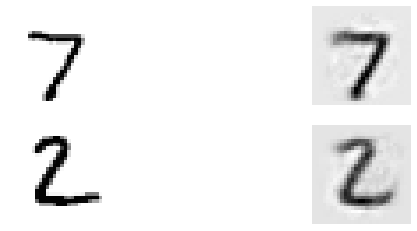

In [44]:
show_reconstructed_digits(inputs, outputs, './model/my_model_one_at_a_time.ckpt')